In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from collections import defaultdict
from itertools import groupby
from matplotlib.lines import Line2D

latent_dim = '10^20'
larochelle = False  # Set true to use standard dataset
results_dir = 'discrete_out_vae_new/' + latent_dim
plotsdir = 'plots'
if larochelle:
    results_dir = results_dir + '/larochelle'
    plotsdir = 'plots/larochelle'
results_dir_sample_kl = results_dir + '/sample_kl'
# For ARSM, use results from sample kl dir
run_files = [
    (results_dir, run) for run in os.listdir(results_dir)
    if 'test' not in run and 'arsm' not in run and 'logvar' not in run and os.path.isfile(os.path.join(results_dir, run))
] + [
    (results_dir_sample_kl, run) for run in os.listdir(results_dir_sample_kl)
    if 'test' not in run and 'arsm' in run and 'logvar' not in run and os.path.isfile(os.path.join(results_dir_sample_kl, run))
]

run_files_logvar = [(results_dir, run) for run in os.listdir(results_dir) if 'test' not in run and 'logvars' in run]

_, runs = zip(*run_files)

os.makedirs(plotsdir, exist_ok=True)

savefigs = True
figsize = (8,5)

In [2]:
def load(name, results_dir):
    try:
        with open(os.path.join(results_dir, name), 'rb') as f:
            return pickle.load(f)
    except:
        print("error", name)
        return None

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color(name):
    if 'unord' in name:
        return colors[0]
    if 'rfwr' in name:
        return colors[1]
    if 'reinforce_bl' in name:
        return colors[2]
    if 'reinforce' in name:
        return colors[6]
    if 'sasbl' in name:
        return colors[3]
    if 'sas' in name:
        return colors[5]
    if 'stgs' in name:
        return colors[8]
    if 'relax' in name:
        return colors[7]
    if 'arsm' in name:
        return colors[4]
    return None

def get_marker(name):
    if 'unord' in name:
        return 'x'
    if 'rfwr' in name:
        return '.'
    if 'reinforce_bl' in name:
        return "v"
    if 'reinforce' in name:
        return ">"
    if 'sasbl' in name:
        return '^'
    if 'sas' in name:
        return '<'
    if 'stgs' in name:
        return 'p'
    if 'relax' in name:
        return 'h'
    if 'arsm' in name:
        return '*'
    return None

pretty_names = {
    'arsm': 'ARSM',
    'reinforce': 'REINFORCE (no bl)',
    'relax': 'RELAX',
    'reinforce_bl': 'REINFORCE (sample bl)',
    'rfwr': 'REINF. w.r. (built-in bl)',
    'rf_unord': 'Unordered (built-in bl)',
    'sas': 'Sum & sample (no bl)',
    'sasbl': 'Sum & sample (sample bl)',
    'stgs': 'ST Gumbel-Softmax'
}


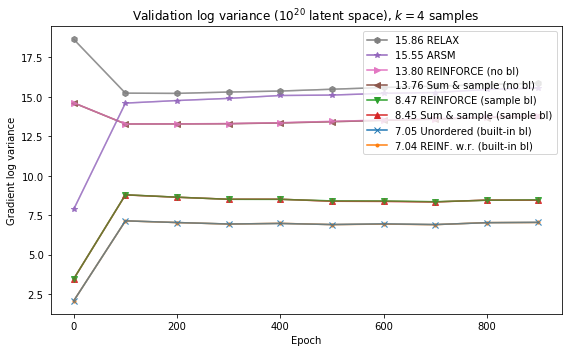

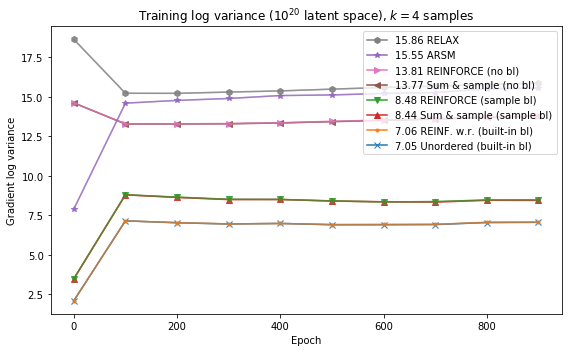

In [4]:
all_results_logvars = [load(name, results_dir) for results_dir, name in run_files_logvar]

for (_, name), results_logvars in zip(run_files_logvar, all_results_logvars):
    fig = plt.figure(figsize=figsize)
    
    ds_name = "Validation" if "valid" in name else "Training"
    K, N = latent_dim.split("^")
    
    # We assume we have run variance experiment with VIMCO ("Reinforce with replacement")
    # with 4 samples (also 4 samples for other estimators)
    if "rfwr4" in name:
        n_samples = 4
    else:
        assert False
    
    plt.title(f"{ds_name} log variance (${K}^{{{N}}}$ latent space), $k={n_samples}$ samples")
    legend_names = []
    legend_lines = []
    
    # Sort estimators by their last log variance
    def sortkey(it):
        _, (logvars_vals, _) = it
        return -logvars_vals[-1]
    
    sorted_results = list(sorted(results_logvars.items(), key=sortkey))
    # To get blending of overlapping colors, we plot twice with reverse direction
    # see https://github.com/matplotlib/matplotlib/issues/4862
    for rev in False, True:
        if rev:
            sorted_results = list(reversed(sorted_results))
        for estimator_name, (logvars_vals, logmeans_vals) in sorted_results:
            c = get_color(estimator_name)
            m = get_marker(estimator_name)
            plt.plot(np.arange(len(logvars_vals)) * 100, logvars_vals, color=c, alpha=0.6, marker=m)
            if not rev:
                legend_lines.append(Line2D([0], [0], color=c, marker=m))
                legend_names.append("{:.2f} {}".format(logvars_vals[-1], pretty_names[estimator_name]))
    
    plt.xlabel('Epoch')
    plt.ylabel('Gradient log variance')
    plt.legend(legend_lines, legend_names, loc='upper right')
    plt.tight_layout()
    plt.show()
    
    if savefigs:
        fig.savefig(f'{plotsdir}/vae_{ds_name[:5].lower()}_logvar_{K}^{N}_k{n_samples}.pdf', format='pdf')

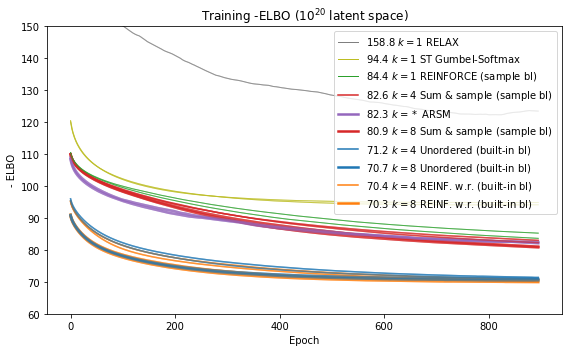

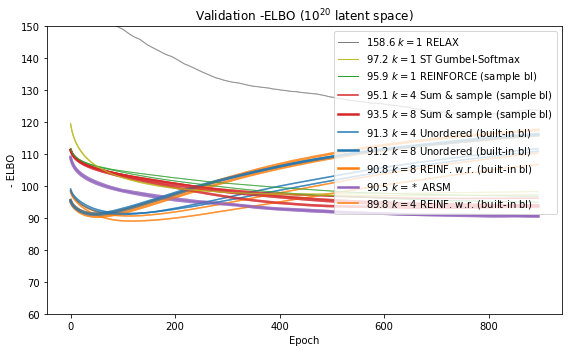

In [5]:
def smooth(data, n=100):
    cs = np.cumsum(data)
    return (cs[n:] - cs[:-n]) / n

all_results = [load(name, results_dir) for results_dir, name in run_files]

def get_estimator_name(name):
    return "_".join(name.split("_")[1:-1])

def sort_by_estimator_name(rec):
    return get_estimator_name(rec[0])

def get_avg_min_cost(all_res, valid):
    all_mincost = []
    for name, res in all_res:
        COUNT,COST,TIME,COST_TEST,COST_VALID,epoch_list,time_list,*evidence_r = res
        all_mincost.append(np.min(smooth(COST_VALID if valid else COST)))
    return np.mean(all_mincost)

def filter_runs(runs, all_results):
    for name, results_run in zip(runs, all_results):
        COUNT,COST,TIME,COST_TEST,COST_VALID,epoch_list,time_list,*evidence_r = results_run
        # Skip some runs that we do not want to plot
        if len(COST_VALID) < 100:
            continue
        if 'test' in name:
            continue
        if 'nodirectgrad' in name:
            continue
        if 'sas' in name and 'sasbl' not in name:
            continue
        if 'reinforce' in name and 'reinforce_bl' not in name:
            continue
        if 'arsm1_lr0.001' in name:
            continue
        yield (name, results_run)

filtered_results = list(filter_runs(runs, all_results))
sorted_results = sorted(filtered_results, key=sort_by_estimator_name)
grouped_results = [(k, list(v)) for k, v in groupby(sorted_results, sort_by_estimator_name)]

for plot_valid in (False, True):
    # Sort by either train or validation result
    sorted_grouped_results = sorted(grouped_results, key=lambda rec: -get_avg_min_cost(rec[1], plot_valid))
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
      
    # To get true blending of overlapping colors, we plot twice with reverse direction
    # see https://github.com/matplotlib/matplotlib/issues/4862
    legend_lines = []
    legend_names = []
    for rev in False, True:
        if rev:
            sorted_grouped_results = list(reversed(sorted_grouped_results))
        for estimator_name_k, results_of_estimator in sorted_grouped_results:
                        
            avgmincost = get_avg_min_cost(results_of_estimator, plot_valid)

            k = int(estimator_name_k[-1])
            estimator_name = estimator_name_k[:-1]

            ls = '-'
            c = get_color(estimator_name)
            alpha1 = 0.6  # Will get darker by drawing two times on top of eachother

            lw = 2.5 if (k > 4 or estimator_name == "arsm") else (1.5 if k > 1 else 1)

            if estimator_name == "arsm":
                k = "*"  # ARSM uses variable number of 'samples' / rollouts

            label = "{:.1f} $k={}$ {}".format(avgmincost, k, pretty_names[estimator_name])
            if not rev:
                # Build legend separately to have alpha=1 for legend
                legend_names.append(label)
                legend_lines.append(Line2D([0], [0], color=c, lw=lw, ls=ls))
            for i, (name, results_run) in enumerate(results_of_estimator):
                COUNT,COST,TIME,COST_TEST,COST_VALID,epoch_list,time_list,*evidence_r = results_run
                ax1.plot(smooth(COST_VALID if plot_valid else COST), 
                         linestyle=ls, color=c, linewidth=lw, alpha=alpha1)
                
    ylim = [60, 150]
    if results_dir.split("/")[1] == '10^2':
        ylim = [130, 160]
    ax1.set_ylim(ylim)
    
    ax1.legend(legend_lines, legend_names, loc='upper right')
    ds_name = 'Validation' if plot_valid else 'Training'
    ax1.set_title('{} -ELBO {}'.format(ds_name, f"(${K}^{{{N}}}$ latent space)"))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('- ELBO')
    
    plt.tight_layout()
    plt.show()
    
    if savefigs:
        fig.savefig(f'{plotsdir}/vae_{ds_name[:5].lower()}_elbo_{K}^{N}.pdf', format='pdf')